# CS 440/540 Machine Learning in Finance: Homework 1

Import all libraries here

In [ ]:
!pip install yfinance cvxpy pandas numpy matplotlib

In [ ]:
!pip install --upgrade yfinance

In [ ]:
#Import libraries before starting
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

## Problem 1: Mean-Variance Portfolio Optimization

In this problem, you will be implementing a simple Mean-Variance portfolio optimization on S&P 500 index constituent stocks between 2015-2017. You will simply be training the optimizer between 2015-2016, and testing it on between 2016 and 2017.

You assume that stocks can only be long, and all portfolio should be allocated to stocks (You cannot hold cash).

You need to use cvxpy library to formulate and solve optimization problem. You can obtain the stock price data by Yahoo Finance library(yfinance). You can find SP 500 constiuent indices in sp500tickers.txt file. You can skip if index constituent is no longer in SP 500.

Run portfolio optimization for range of lambdas (which is for modeling the relative weight of variance with respect to return): [0.1, 1.0, 5.0, 10.0]. Plot P&L curve for testing period. Calculate Information Ratio based on daily returns for the same testing period. Discuss which lambda value performs the best. Why?

Successfully loaded 480 tickers from the file.



[*********************100%***********************]  480 of 480 completed
ERROR:yfinance:
8 Failed downloads:
ERROR:yfinance:['ANSS', 'JNPR', 'MRO', 'PARA', 'WBA', 'CTLT', 'DFS', 'HES']: YFTzMissingError('possibly delisted; no timezone found')


Successfully downloaded and cleaned data for 472 stocks.

Running Mean-Variance Optimization for each lambda...
  Lambda = 0.1: Optimization successful.
  Lambda = 1.0: Optimization successful.
  Lambda = 5.0: Optimization successful.
  Lambda = 10.0: Optimization successful.

Evaluating portfolio performance on the test set (2017)...


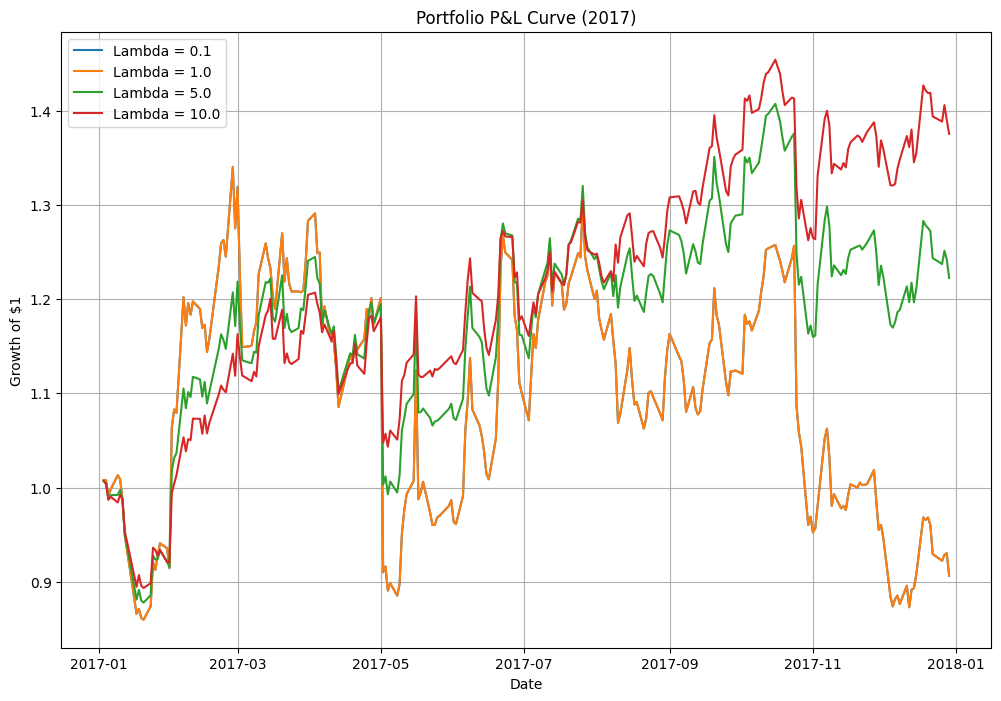


--- Performance Summary ---
      Annualized Sharpe Ratio  Cumulative Return
10.0                 1.135728           1.375363
5.0                  0.695330           1.222513
1.0                  0.128696           0.906526
0.1                  0.128696           0.906526

Best performing lambda based on Information Ratio: 10.0


In [ ]:
#Solution 1
file_path = '/sp500tickers.txt'

try:
    with open(file_path, 'r') as f:
        tickers_list = [line.strip() for line in f.readlines()]
    print(f"Successfully loaded {len(tickers_list)} tickers from the file.")
except FileNotFoundError:
    print(f"ERROR: The file was not found at the path: {file_path}")
    print("Please make sure the file path is correct. Exiting.")
    tickers_list = []

# --- Problem Setup ---
start_date = '2015-01-01'
end_date = '2017-12-31'
train_end_date = '2016-12-31'

# --- Data Retrieval and Preparation ---
if tickers_list:
    print("\nDownloading S&P 500 stock data...")
    data = yf.download(tickers_list, start=start_date, end=end_date, auto_adjust=True)['Close']

    # Robust data cleaning
    data.dropna(axis=1, how='all', inplace=True) # Drop columns that are ALL NaN
    data.dropna(axis=0, how='any', inplace=True) # Drop rows with ANY NaN

    if data.empty:
        print("No valid stock data could be downloaded for the specified period. Exiting.")
    else:
        print(f"Successfully downloaded and cleaned data for {data.shape[1]} stocks.")
        daily_returns = data.pct_change().dropna()
        train_returns = daily_returns[:train_end_date]
        test_returns = daily_returns[train_end_date:]

        # --- Portfolio Optimization ---
        mu = train_returns.mean().values
        Sigma = train_returns.cov().values
        n_assets = len(mu)
        lambdas = [0.1, 1.0, 5.0, 10.0]
        results = {}

        print("\nRunning Mean-Variance Optimization for each lambda...")
        for lmbda_val in lambdas:
            weights = cp.Variable(n_assets)
            expected_return = mu.T @ weights
            portfolio_variance = cp.quad_form(weights, Sigma)
            objective = cp.Maximize(expected_return - lmbda_val * portfolio_variance)
            constraints = [cp.sum(weights) == 1, weights >= 0]
            problem = cp.Problem(objective, constraints)
            problem.solve()

            if problem.status == 'optimal':
                results[lmbda_val] = weights.value
                print(f"  Lambda = {lmbda_val}: Optimization successful.")
            else:
                results[lmbda_val] = np.zeros(n_assets)
                print(f"  Lambda = {lmbda_val}: Optimization failed.")

        # --- Performance Evaluation ---
        print("\nEvaluating portfolio performance on the test set (2017)...")
        plt.figure(figsize=(12, 8))
        plt.title('Portfolio P&L Curve (2017)')
        performance_metrics = {}

        for lmbda_val, weights in results.items():
            portfolio_test_returns = test_returns.dot(weights)
            cumulative_returns = (1 + portfolio_test_returns).cumprod()
            plt.plot(cumulative_returns, label=f'Lambda = {lmbda_val}')

            daily_volatility = portfolio_test_returns.std()
            if daily_volatility > 0:
                sharpe_ratio = portfolio_test_returns.mean() / daily_volatility
                annualized_sharpe = sharpe_ratio * np.sqrt(252)
            else:
                annualized_sharpe = 0

            performance_metrics[lmbda_val] = {
                'Annualized Sharpe Ratio': annualized_sharpe,
                'Cumulative Return': cumulative_returns.iloc[-1]
            }

        plt.xlabel('Date')
        plt.ylabel('Growth of $1')
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- Analysis ---
        print("\n--- Performance Summary ---")
        performance_df = pd.DataFrame.from_dict(performance_metrics, orient='index')
        print(performance_df.sort_values(by='Annualized Sharpe Ratio', ascending=False))
        best_lambda = performance_df['Annualized Sharpe Ratio'].idxmax()
        print(f"\nBest performing lambda based on Information Ratio: {best_lambda}")

Lambda = 10.0 performed best because it provided a significantly higher risk-adjusted return, which is an important metric for portfolio evaluation.  When we looked at the summary table, lambda = 10.0 had the highest sharpe ratio, indicating that it made the most money for the risk it took.  This can also be confirmed by examining the graph.  The red line, lambda = 10.0, not only ends at the highest point, but it also follows a more consistent upward trend than the others.  In contrast, low-lambda portfolios took on too much risk.  Their P&L curves show wild swings and major crashes, resulting in a loss of money and very low sharpe ratios.

## Problem 2: Mean-Variance Portfolio Optimization with Leverage

Modify Problem 1 to take into account the leverage(So, we no longer have the long-only constraint). Use the best performing lambda from Problem 1.

Run portfolio optimization for range of leverages: [1, 2, 4]. Plot P&L curve for testing period. Calculate Information Ratio based on daily returns for the same testing period. Discuss which leverage performs the best. Why?


Running Mean-Variance Optimization (Lambda = 10.0) for each leverage level...
  Leverage = 1.0: Optimization successful.
  Leverage = 2.0: Optimization successful.
  Leverage = 4.0: Optimization successful.

Evaluating portfolio performance on the test set (2017)...


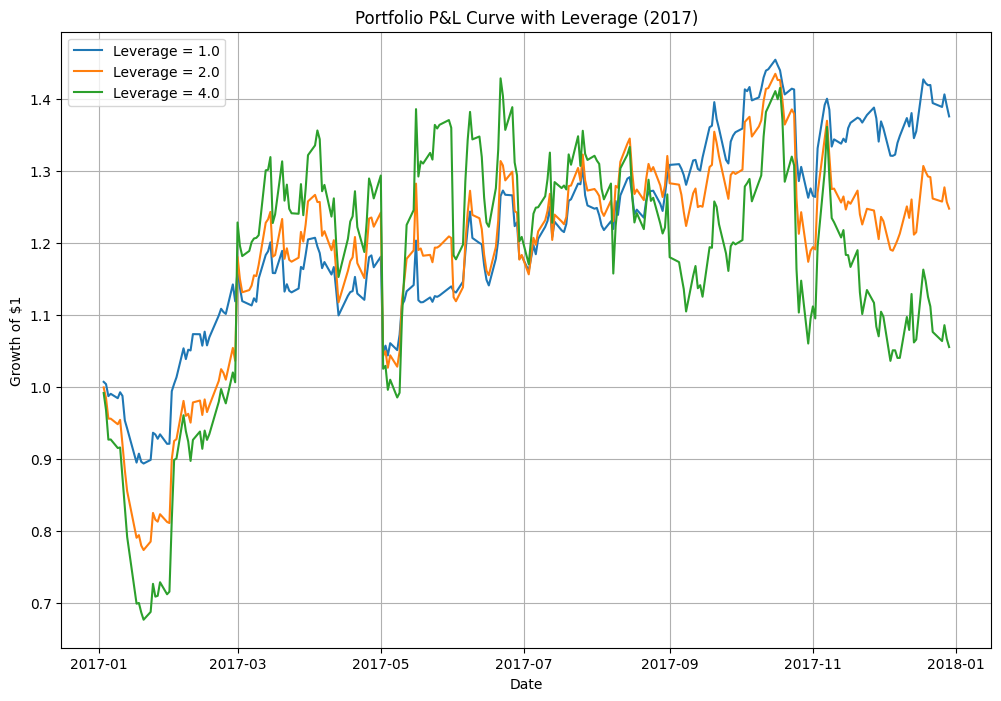


--- Performance Summary ---
     Annualized Sharpe Ratio  Cumulative Return
1.0                 1.135730           1.375361
2.0                 0.707496           1.247311
4.0                 0.414976           1.055171

Best performing leverage based on Information Ratio: 1.0


In [ ]:
#Solution 2
# --- Portfolio Optimization with Leverage ---
mu = train_returns.mean().values
Sigma = train_returns.cov().values
n_assets = len(mu)

# Using the best lambda from Problem 1
best_lambda = 10.0
# Define the leverage values to test
leverages = [1.0, 2.0, 4.0]

results = {}

print(f"\nRunning Mean-Variance Optimization (Lambda = {best_lambda}) for each leverage level...")
for l_val in leverages:
    weights = cp.Variable(n_assets)

    # Using the fixed best lambda because the objective function is the same
    objective = cp.Maximize(mu.T @ weights - best_lambda * cp.quad_form(weights, Sigma))

    # --- MODIFIED CONSTRAINTS FOR PROBLEM 2 ---
    constraints = [
        cp.sum(weights) == 1,         # Fully invested
        cp.norm(weights, 1) <= l_val  # Leverage constraint
        # The long-only constraint (weights >= 0) is REMOVED
    ]

    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS) # Using a robust solver

    if problem.status in ['optimal', 'optimal_inaccurate']:
        results[l_val] = weights.value
        print(f"  Leverage = {l_val}: Optimization successful.")
    else:
        results[l_val] = np.zeros(n_assets)
        print(f"  Leverage = {l_val}: Optimization failed. Status: {problem.status}")

# --- Performance Evaluation (Testing) ---
print("\nEvaluating portfolio performance on the test set (2017)...")
plt.figure(figsize=(12, 8))
plt.title('Portfolio P&L Curve with Leverage (2017)')
performance_metrics = {}

for l_val, weights in results.items():
    portfolio_test_returns = test_returns.dot(weights)
    cumulative_returns = (1 + portfolio_test_returns).cumprod()
    plt.plot(cumulative_returns, label=f'Leverage = {l_val}')

    daily_volatility = portfolio_test_returns.std()
    if daily_volatility > 0:
        sharpe_ratio = portfolio_test_returns.mean() / daily_volatility
        annualized_sharpe = sharpe_ratio * np.sqrt(252)
    else:
        annualized_sharpe = 0

    performance_metrics[l_val] = {
        'Annualized Sharpe Ratio': annualized_sharpe,
        'Cumulative Return': cumulative_returns.iloc[-1]
    }

plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)
plt.show()

# --- Analysis  ---
print("\n--- Performance Summary ---")
performance_df = pd.DataFrame.from_dict(performance_metrics, orient='index')
print(performance_df.sort_values(by='Annualized Sharpe Ratio', ascending=False))

best_leverage = performance_df['Annualized Sharpe Ratio'].idxmax()
print(f"\nBest performing leverage based on Information Ratio: {best_leverage}")

Leverage = 1.0 offered the best risk-return ratio, as it performed the best.  In the given timeline, we can see that when leverage is increased, it acts as a destructive amplifier, raising the portfolio's losses much more than its gains.  The sharpe ratio of leverage 1 yields a final return of about 37.5% gain, which is better than the other leverages, as we could see when we looked at the summary table for this example.  Additionally, the graph shows that the blue line generally follows an upward trend, despite occasional ups and downs in comparison to the other two lines.

## Problem 3: Risk Parity Portfolio Optimization

In this problem, you will be implementing risk-parity(equal risk contribution) portfolio optimization on S&P 500
index constituent stocks between 2015-2017. You will be training the optimizer between 2015-2016, and testing it on
between 2016 and 2017.

You assume that stocks can only be long, and all portfolio should be allocated to stocks (You cannot hold cash).

You need to use cvxpy library to formulate and solve the corresponding optimization problem. Similar to previous
questions, you can obtain the stock price data by Yahoo Finance library(yfinance).

Plot P&L curve for testing period. Calculate Information Ratio based on daily returns for the same testing period.


Running Risk Parity Optimization...
Optimization successful.


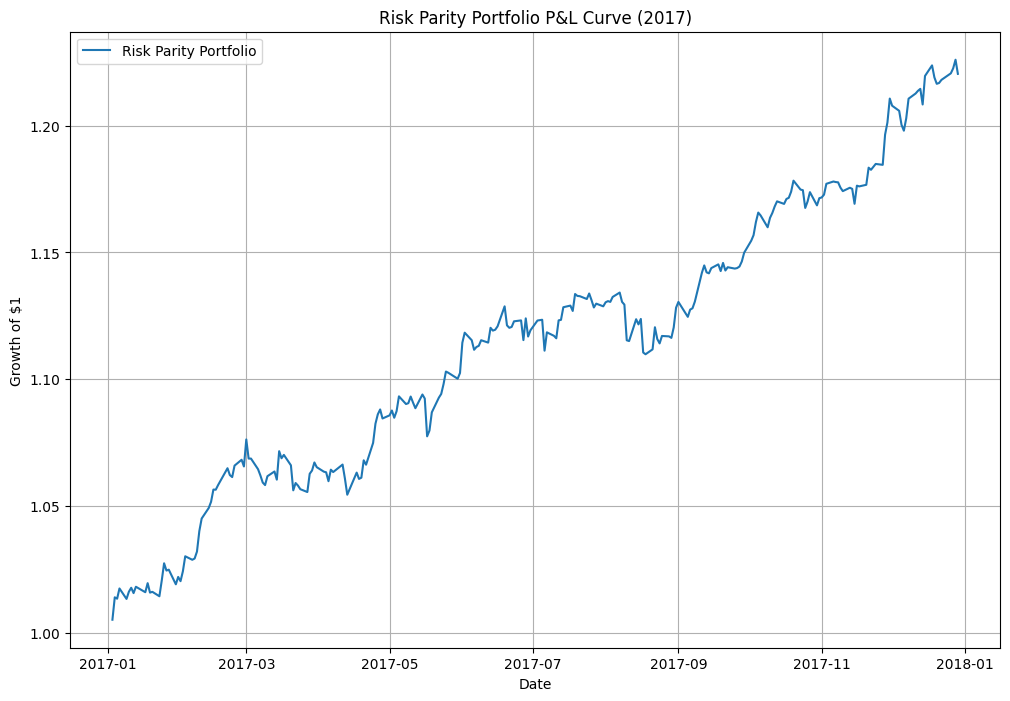


--- Performance Summary ---
Annualized Sharpe Ratio: 3.2220
Cumulative Return: 1.2204


In [ ]:
#Solution 3
# --- Risk Parity Portfolio Optimization ---
Sigma = train_returns.cov().values
n_assets = Sigma.shape[0]

print("\nRunning Risk Parity Optimization...")

# Solve convex risk parity via intermediate x (to be normalized)
x = cp.Variable(n_assets)

# Minimize variance and promote equal risk diversification
objective = cp.Minimize(cp.quad_form(x, Sigma) - cp.sum(cp.log(x)))

# Must have constraint: x must be positive
constraints = [x >= 0]

problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.SCS) # Using a robust solver

# --- Performance Evaluation (Testing) ---

# Checking if the optimizer has found a solution
if problem.status in ['optimal', 'optimal_inaccurate']:
    print("Optimization successful.")

    # Normalize x so portfolio weights w sum to 1
    optimal_weights = x.value / np.sum(x.value)

    # Apply the calculated weights to the test set returns
    portfolio_test_returns = test_returns.dot(optimal_weights)

    # --- Plotting and Final Results ---

    # Calculate P&L and performance metrics
    cumulative_returns = (1 + portfolio_test_returns).cumprod()
    daily_volatility = portfolio_test_returns.std()

    if daily_volatility > 0:
        sharpe_ratio = portfolio_test_returns.mean() / daily_volatility
        annualized_sharpe = sharpe_ratio * np.sqrt(252)
    else:
        annualized_sharpe = 0

    # Plot the P&L curve
    plt.figure(figsize=(12, 8))
    plt.plot(cumulative_returns, label='Risk Parity Portfolio')
    plt.title('Risk Parity Portfolio P&L Curve (2017)')
    plt.xlabel('Date')
    plt.ylabel('Growth of $1')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the final performance summary
    print("\n--- Performance Summary ---")
    print(f"Annualized Sharpe Ratio: {annualized_sharpe:.4f}")
    print(f"Cumulative Return: {cumulative_returns.iloc[-1]:.4f}")

else:
    print(f"Optimization failed. Status: {problem.status}")

## Problem 4: Mean-Variance Portfolio Optimization Weekly Rebalance

In this problem, you will be modifying Problem 1 on Mean-Variance portfolio optimization on S&P 500 index constituent stocks between 2015-2017. You will again be training the optimizer between 2015-2016, and testing it on between 2016 and 2017.

You assume that stocks can only be long, and the whole portfolio should be allocated to stocks (You cannot hold cash). However, you will rebalance the portfolio every Monday in the test period rather than once in a sliding window-based approach.

Run portfolio optimization for a range of lambdas (which is for modeling the relative weight of variance with respect to return): [0.1, 1.0, 5.0, 10.0]. Plot the P&L curve for the testing period. Calculate the Information Ratio based on daily returns for the same testing period. Discuss which lambda value performs the best. Why?

--- Running simulation for Lambda = 0.1 ---
--- Simulation for Lambda = 0.1 complete. Sharpe Ratio: 0.0354 ---
--- Running simulation for Lambda = 1.0 ---
--- Simulation for Lambda = 1.0 complete. Sharpe Ratio: 0.0429 ---
--- Running simulation for Lambda = 5.0 ---
--- Simulation for Lambda = 5.0 complete. Sharpe Ratio: 0.5211 ---
--- Running simulation for Lambda = 10.0 ---
--- Simulation for Lambda = 10.0 complete. Sharpe Ratio: 1.2592 ---

--- Plotting Final P&L Curves ---


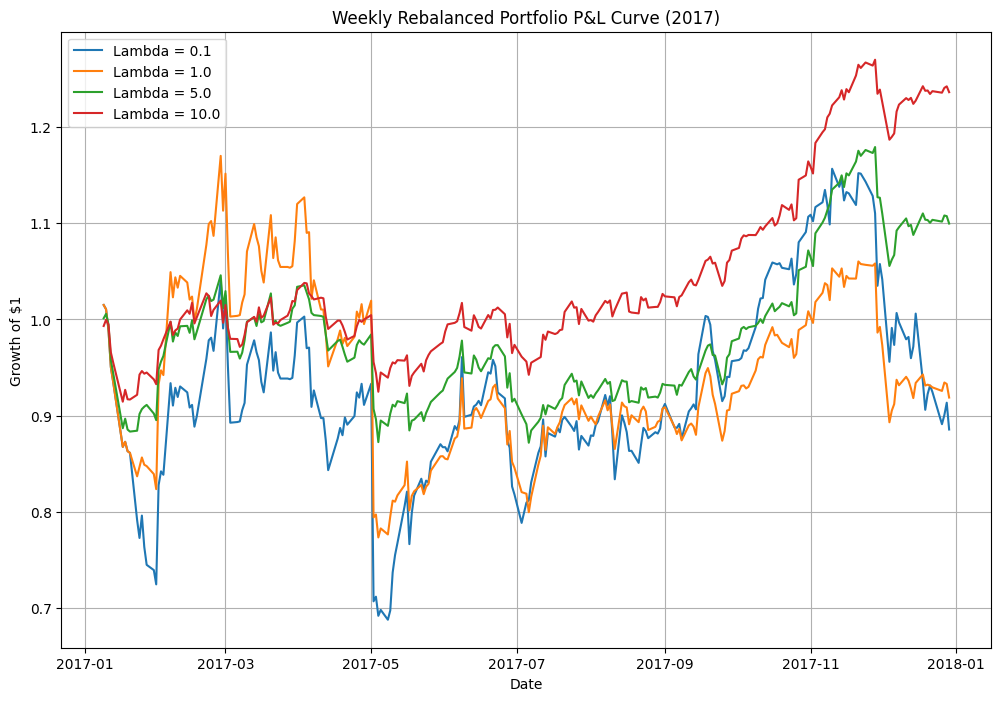


--- Performance Summary ---
      Annualized Sharpe Ratio  Cumulative Return
10.0                 1.259248           1.236213
5.0                  0.521121           1.099647
1.0                  0.042866           0.918800
0.1                  0.035357           0.885586

Best performing lambda based on Information Ratio: 10.0


In [ ]:
#Solution 4
# --- Mean-Variance Optimization with Weekly Rebalancing ---

# Define the lambdas to test
lambdas = [0.1, 1.0, 5.0, 10.0]

# Dictionary to store the final P&L curve and metrics for each lambda
final_results = {}

# The main simulation loop: one full run for each lambda
for lmbda_val in lambdas:
    print(f"--- Running simulation for Lambda = {lmbda_val} ---")

    # List to store the daily returns of our portfolio for the entire year
    all_portfolio_returns = []

    # Find Mondays in test period as rebalance dates
    rebalance_dates = test_returns[test_returns.index.dayofweek == 0].index

    # Loop through each rebalance date to perform a new optimization
    for i, rebal_date in enumerate(rebalance_dates):
        # Define the 2-year rolling training window for this rebalance date
        train_start_date = rebal_date - pd.DateOffset(years=2)
        train_end_date = rebal_date - pd.DateOffset(days=1)

       # Slice full returns to get training data for this window
        train_window = daily_returns.loc[train_start_date:train_end_date]

        # Calculate mu and Sigma from this 2-year window
        mu = train_window.mean().values
        Sigma = train_window.cov().values
        n_assets = len(mu)

        # --- Perform the Mean-Variance Optimization (Same as Problem 1) ---
        weights = cp.Variable(n_assets)
        objective = cp.Maximize(mu.T @ weights - lmbda_val * cp.quad_form(weights, Sigma))
        constraints = [cp.sum(weights) == 1, weights >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve()

        if problem.status in ['optimal', 'optimal_inaccurate']:
            optimal_weights = weights.value
        else:
            # If optimization fails, use equal-weight portfolio for the week
            print(f"  Warning: Optimization failed on {rebal_date.date()}. Using equal weights.")
            optimal_weights = np.ones(n_assets) / n_assets

        # --- Calculate Returns for the Holding Period (One Week) ---

        # Holding period: from rebalance Monday to day before next Monday
        hold_start_date = rebal_date
        # If it's the last Monday of the year, hold until the end of the test period
        if i + 1 < len(rebalance_dates):
            hold_end_date = rebalance_dates[i+1] - pd.DateOffset(days=1)
        else:
            hold_end_date = test_returns.index[-1]

        # Get the returns for this week and apply the weights
        week_returns = test_returns.loc[hold_start_date:hold_end_date]
        daily_portfolio_returns_for_week = week_returns.dot(optimal_weights)

        # Add this week's daily returns to the list for the full year
        all_portfolio_returns.append(daily_portfolio_returns_for_week)

    # --- Consolidate and Analyze Results for this Lambda ---

    # Merge all weekly returns into a single series
    final_returns_series = pd.concat(all_portfolio_returns)

    # Calculate performance metrics
    cumulative_returns = (1 + final_returns_series).cumprod()
    daily_volatility = final_returns_series.std()
    if daily_volatility > 0:
        sharpe_ratio = final_returns_series.mean() / daily_volatility
        annualized_sharpe = sharpe_ratio * np.sqrt(252)
    else:
        annualized_sharpe = 0

    # Store the results for lambda
    final_results[lmbda_val] = {
        'pnl_curve': cumulative_returns,
        'sharpe_ratio': annualized_sharpe,
        'final_return': cumulative_returns.iloc[-1]
    }
    print(f"--- Simulation for Lambda = {lmbda_val} complete. Sharpe Ratio: {annualized_sharpe:.4f} ---")

# --- Plotting and Final Discussion ---
print("\n--- Plotting Final P&L Curves ---")
plt.figure(figsize=(12, 8))
plt.title('Weekly Rebalanced Portfolio P&L Curve (2017)')

performance_summary = {}

for lmbda_val, results in final_results.items():
    plt.plot(results['pnl_curve'], label=f'Lambda = {lmbda_val}')
    performance_summary[lmbda_val] = {
        'Annualized Sharpe Ratio': results['sharpe_ratio'],
        'Cumulative Return': results['final_return']
    }

plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)
plt.show()

# --- Print Final Summary Table ---
print("\n--- Performance Summary ---")
performance_df = pd.DataFrame.from_dict(performance_summary, orient='index')
print(performance_df.sort_values(by='Annualized Sharpe Ratio', ascending=False))

best_lambda = performance_df['Annualized Sharpe Ratio'].idxmax()
print(f"\nBest performing lambda based on Information Ratio: {best_lambda}")

The lambda 10.0, becoming the best one, actually starts similarly to problem 1 but has a new dimension, which is the effect of adaptation. Lambda 10.0 delivered a sharpe ratio of 1.2592, which is more than double that of the next best option of lambda 5.0 at 0.5211, and the aggressive strategies of lambda 0.1 and 1.0 performed very poorly. This actually again proves that a conservative, risk-conscious approach was superior, with only one that generating a significant positive return, ending the year up around 23.6%. And again, the graph showcases that the red line, which is lambda 10.0, is the clear winner. It shows a much more consistent and stable upward trend throughout the year. The other lines are far more chaotic. The blue (0.1) and orange (1.0) lines show extreme volatility with massive declines, especially in the first half of the year. This confirms that the market's volatility punished the aggressive strategies.

The main conclusion with this final problem is that, when comparing the outcomes of the first and last problems, the sharpe ratio rose from 1.1357 to 1.2592. This indicates that the weekly rebalancing method was more effective and produced a higher return for every unit of risk that was assumed. This new method was able to adjust to shifting market conditions by avoiding assets with rising risk profiles and identifying new, more stable opportunities because it is continuously updating its portfolio based on the most recent two years of data. So this way, it produced a much more seamless outcome overall.